In [661]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn import datasets
import os

# Load Datasets

In [662]:
d = datasets.load_digits(as_frame=True)
digits = d['data']
digits_target = d['target']

c = datasets.fetch_openml(name='credit-g', as_frame=True)
credit = c['data']
credit_target = c['target']

from sklearn.model_selection import train_test_split
digits, digits_test, digits_target, digits_target_test = train_test_split(digits, digits_target, test_size = 0.2, random_state = 0)

credit, credit_test, credit_target, credit_target_test = train_test_split(credit, credit_target, test_size = 0.2, random_state = 0)



## Preprocess Digits

## Preprocess Credit

In [663]:
#everything good except cat to one hot
credit_cat = ['checking_status', 'credit_history', 'savings_status', 'employment', 'personal_status', 'other_parties',
             'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker']

def extract_columns (df, cols):
    return df.loc[:, cols]

def get_onehot (df, cat_feat):
    categories = extract_columns(df, cat_feat)
    le = LabelEncoder()
    return categories.apply(lambda col: le.fit_transform(col))

one_hot_cols = get_onehot(credit, credit_cat)
one_hot_cols_test = get_onehot(credit_test, credit_cat)
credit_no_cat = credit.drop(credit_cat, axis = 1) 
credit = pd.concat([credit_no_cat, one_hot_cols], axis=1)
print (credit)


     duration              purpose  credit_amount  installment_commitment  \
687      36.0              new car         2862.0                     4.0   
500      24.0              new car         3123.0                     4.0   
332      60.0              new car         7408.0                     4.0   
979      15.0              new car         1264.0                     2.0   
817       6.0             radio/tv         1554.0                     1.0   
..        ...                  ...            ...                     ...   
835      12.0              new car         1082.0                     4.0   
192      27.0             business         3915.0                     4.0   
629       9.0            education         3832.0                     1.0   
559      18.0  furniture/equipment         1928.0                     2.0   
684      36.0             business         9857.0                     1.0   

     residence_since   age  existing_credits  num_dependents  checking_stat

In [664]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.sparse

In [665]:
import numpy as np
from time import time
#from .._base import _BaseClassifier
#from .._base import _BaseMultiClass


class SoftmaxRegression(object):

    """Softmax regression classifier.

    Parameters
    ------------
    eta : float (default: 0.01)
        Learning rate (between 0.0 and 1.0)
    epochs : int (default: 50)
        Passes over the training dataset.
        Prior to each epoch, the dataset is shuffled
        if `minibatches > 1` to prevent cycles in stochastic gradient descent.
    l2 : float
        Regularization parameter for L2 regularization.
        No regularization if l2=0.0.
    minibatches : int (default: 1)
        The number of minibatches for gradient-based optimization.
        If 1: Gradient Descent learning
        If len(y): Stochastic Gradient Descent (SGD) online learning
        If 1 < minibatches < len(y): SGD Minibatch learning
    n_classes : int (default: None)
        A positive integer to declare the number of class labels
        if not all class labels are present in a partial training set.
        Gets the number of class labels automatically if None.
    random_seed : int (default: None)
        Set random state for shuffling and initializing the weights.

    Attributes
    -----------
    w_ : 2d-array, shape={n_features, 1}
      Model weights after fitting.
    b_ : 1d-array, shape={1,}
      Bias unit after fitting.
    cost_ : list
        List of floats, the average cross_entropy for each epoch.

    """
    def __init__(self, eta=0.01, epochs=50,
                 l2=0.0,
                 minibatches=1,
                 n_classes=None,
                 random_seed=None):

        self.eta = eta
        self.epochs = epochs
        self.l2 = l2
        self.minibatches = minibatches
        self.n_classes = n_classes
        self.random_seed = random_seed

    def _fit(self, X, y, init_params=True):
        if init_params:
            if self.n_classes is None:
                self.n_classes = np.max(y) + 1
            self._n_features = X.shape[1]

            self.b_, self.w_ = self._init_params(
                weights_shape=(self._n_features, self.n_classes),
                bias_shape=(self.n_classes,),
                random_seed=self.random_seed)
            self.cost_ = []

        y_enc = self._one_hot(y=y, n_labels=self.n_classes, dtype=np.float)
     

        for i in range(self.epochs):
            for idx in self._yield_minibatches_idx(
                    n_batches=self.minibatches,
                    data_ary=y,
                    shuffle=True):
                # givens:
                # w_ -> n_feat x n_classes
                # b_  -> n_classes

                # net_input, softmax and diff -> n_samples x n_classes:
                net = self._net_input(X[idx], self.w_, self.b_)
                softm = self._softmax(net)
                diff = softm - y_enc[idx]
                mse = np.mean(diff, axis=0)

                # gradient -> n_features x n_classes
                grad = np.dot(X[idx].T, diff)
                
                # update in opp. direction of the cost gradient
                self.w_ -= (self.eta * grad +
                            self.eta * self.l2 * self.w_)
                self.b_ -= (self.eta * np.sum(diff, axis=0))

            # compute cost of the whole epoch
            net = self._net_input(X, self.w_, self.b_)
            softm = self._softmax(net)
            cross_ent = self._cross_entropy(output=softm, y_target=y_enc)
            cost = self._cost(cross_ent)
            self.cost_.append(cost)
        return self

    def fit(self, X, y, init_params=True):
        """Learn model from training data.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.
        init_params : bool (default: True)
            Re-initializes model parametersprior to fitting.
            Set False to continue training with weights from
            a previous model fitting.

        Returns
        -------
        self : object

        """
        if self.random_seed is not None:
            np.random.seed(self.random_seed)
        self._fit(X=X, y=y, init_params=init_params)
        self._is_fitted = True
        return self
    
    def _predict(self, X):
        probas = self.predict_proba(X)
        return self._to_classlabels(probas)
 
    def predict(self, X):
        """Predict targets from X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        ----------
        target_values : array-like, shape = [n_samples]
          Predicted target values.

        """
        if not self._is_fitted:
            raise AttributeError('Model is not fitted, yet.')
        return self._predict(X)

    def predict_proba(self, X):
        """Predict class probabilities of X from the net input.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        ----------
        Class probabilties : array-like, shape= [n_samples, n_classes]

        """
        net = self._net_input(X, self.w_, self.b_)
        softm = self._softmax(net)
        return softm

    def _net_input(self, X, W, b):
        return (X.dot(W) + b)

    def _softmax(self, z):
        return (np.exp(z.T) / np.sum(np.exp(z), axis=1)).T

    def _cross_entropy(self, output, y_target):
        return - np.sum(np.log(output) * (y_target), axis=1)

    def _cost(self, cross_entropy):
        L2_term = self.l2 * np.sum(self.w_ ** 2)
        cross_entropy = cross_entropy + L2_term
        return 0.5 * np.mean(cross_entropy)

    def _to_classlabels(self, z):
        return z.argmax(axis=1)
    
    def _init_params(self, weights_shape, bias_shape=(1,), dtype='float64',
                     scale=0.01, random_seed=None):
        """Initialize weight coefficients."""
        if random_seed:
            np.random.seed(random_seed)
        w = np.random.normal(loc=0.0, scale=scale, size=weights_shape)
        b = np.zeros(shape=bias_shape)
        return b.astype(dtype), w.astype(dtype)
    
    def _one_hot(self, y, n_labels, dtype):
        """Returns a matrix where each sample in y is represented
           as a row, and each column represents the class label in
           the one-hot encoding scheme.

        Example:

            y = np.array([0, 1, 2, 3, 4, 2])
            mc = _BaseMultiClass()
            mc._one_hot(y=y, n_labels=5, dtype='float')

            np.array([[1., 0., 0., 0., 0.],
                      [0., 1., 0., 0., 0.],
                      [0., 0., 1., 0., 0.],
                      [0., 0., 0., 1., 0.],
                      [0., 0., 0., 0., 1.],
                      [0., 0., 1., 0., 0.]])

        """
        mat = np.zeros((len(y), n_labels))
        for i, val in enumerate(y):
            mat[i, val] = 1
        return mat.astype(dtype)    
    
    def _yield_minibatches_idx(self, n_batches, data_ary, shuffle=True):
            indices = np.arange(data_ary.shape[0])

            if shuffle:
                indices = np.random.permutation(indices)
            if n_batches > 1:
                remainder = data_ary.shape[0] % n_batches

                if remainder:
                    minis = np.array_split(indices[:-remainder], n_batches)
                    minis[-1] = np.concatenate((minis[-1],
                                                indices[-remainder:]),
                                               axis=0)
                else:
                    minis = np.array_split(indices, n_batches)

            else:
                minis = (indices,)

            for idx_batch in minis:
                yield idx_batch
    
    def _shuffle_arrays(self, arrays):
        """Shuffle arrays in unison."""
        r = np.random.permutation(len(arrays[0]))
        return [ary[r] for ary in arrays]

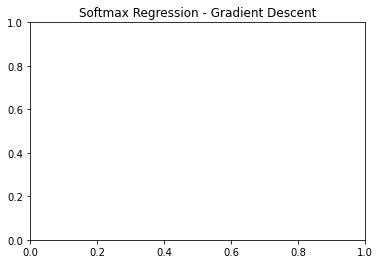

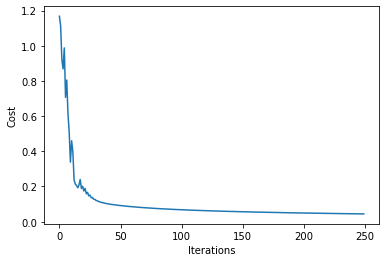

In [666]:
from mlxtend.data import iris_data
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt

# Loading Data

#X = one_hot_cols.values
#y = credit_target.values

X = digits.values
y = digits_target.values

# standardize
#X[:,0] = (X[:,0] - X[:,0].mean()) / X[:,0].std()
#X[:,1] = (X[:,1] - X[:,1].mean()) / X[:,1].std()

lr = SoftmaxRegression(eta=0.00001, epochs=250, minibatches=1, random_seed=0)
lr.fit(X, y)

#X_plt = X[:, [0,1]]

#plot_decision_regions(X_plt, y, clf=lr)
plt.title('Softmax Regression - Gradient Descent')
plt.show()

plt.plot(range(len(lr.cost_)), lr.cost_)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

In [667]:
digits_target_test.values[0:]

array([2, 8, 2, 6, 6, 7, 1, 9, 8, 5, 2, 8, 6, 6, 6, 6, 1, 0, 5, 8, 8, 7,
       8, 4, 7, 5, 4, 9, 2, 9, 4, 7, 6, 8, 9, 4, 3, 1, 0, 1, 8, 6, 7, 7,
       1, 0, 7, 6, 2, 1, 9, 6, 7, 9, 0, 0, 5, 1, 6, 3, 0, 2, 3, 4, 1, 9,
       2, 6, 9, 1, 8, 3, 5, 1, 2, 8, 2, 2, 9, 7, 2, 3, 6, 0, 5, 3, 7, 5,
       1, 2, 9, 9, 3, 1, 7, 7, 4, 8, 5, 8, 5, 5, 2, 5, 9, 0, 7, 1, 4, 7,
       3, 4, 8, 9, 7, 9, 8, 2, 6, 5, 2, 5, 8, 4, 8, 7, 0, 6, 1, 5, 9, 9,
       9, 5, 9, 9, 5, 7, 5, 6, 2, 8, 6, 9, 6, 1, 5, 1, 5, 9, 9, 1, 5, 3,
       6, 1, 8, 9, 8, 7, 6, 7, 6, 5, 6, 0, 8, 8, 9, 8, 6, 1, 0, 4, 1, 6,
       3, 8, 6, 7, 4, 5, 6, 3, 0, 3, 3, 3, 0, 7, 7, 5, 7, 8, 0, 7, 8, 9,
       6, 4, 5, 0, 1, 4, 6, 4, 3, 3, 0, 9, 5, 9, 2, 1, 4, 2, 1, 6, 8, 9,
       2, 4, 9, 3, 7, 6, 2, 3, 3, 1, 6, 9, 3, 6, 3, 2, 2, 0, 7, 6, 1, 1,
       9, 7, 2, 7, 8, 5, 5, 7, 5, 2, 3, 7, 2, 7, 5, 5, 7, 0, 9, 1, 6, 5,
       9, 7, 4, 3, 8, 0, 3, 6, 4, 6, 3, 2, 6, 8, 8, 8, 4, 6, 7, 5, 2, 4,
       5, 3, 2, 4, 6, 9, 4, 5, 4, 3, 4, 6, 2, 9, 0,

In [668]:

y_pred = lr.predict(digits_test.values)
print('Last 2 Class Labels: %s' % y_pred[0:])



Last 2 Class Labels: [2 8 2 6 6 7 1 9 8 5 2 8 6 6 6 6 1 0 5 8 8 7 8 4 7 5 4 9 2 9 4 7 6 8 9 4 3
 1 0 1 8 6 7 7 1 0 7 6 2 1 9 6 7 9 0 0 9 1 6 3 0 2 3 4 1 9 2 6 9 1 8 3 5 1
 2 8 2 2 9 7 2 3 6 0 5 3 7 5 1 2 9 9 3 1 4 7 4 8 5 8 5 5 2 5 9 0 7 1 4 7 3
 4 8 9 7 9 8 2 1 5 2 5 8 4 1 7 0 6 1 5 5 9 9 5 9 9 5 7 5 6 2 8 6 9 6 1 5 1
 5 9 9 1 5 3 6 1 8 9 8 7 6 7 6 5 6 0 8 8 9 8 6 1 0 4 1 6 3 8 6 7 4 9 6 3 0
 3 3 3 0 7 7 5 7 8 0 7 1 9 6 4 5 0 1 4 6 4 3 3 0 9 5 9 2 1 4 2 1 6 8 9 2 4
 9 3 7 6 2 3 3 1 6 9 3 6 3 2 2 0 7 6 1 1 9 7 2 7 8 5 5 7 5 2 3 7 2 7 5 5 7
 0 9 1 6 5 9 7 4 3 8 0 3 6 4 6 3 2 6 8 8 8 4 6 7 5 2 4 5 3 2 4 6 9 4 5 4 3
 4 6 2 9 0 6 7 2 0 9 6 0 4 2 0 7 9 8 5 7 8 2 8 4 3 7 2 6 9 9 5 1 0 8 2 8 9
 5 6 2 2 7 2 1 5 1 6 4 5 0 9 4 1 1 7 0 8 9 0 5 4 3 8 8]


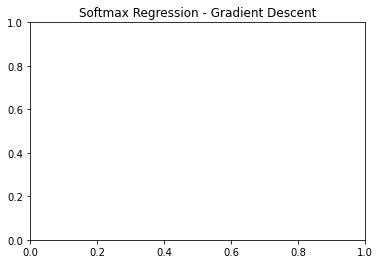

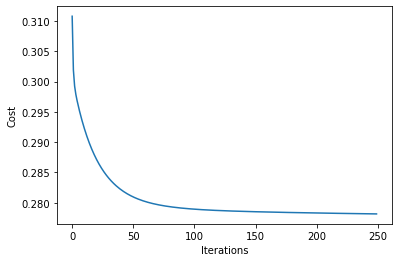

In [669]:
from mlxtend.data import iris_data
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt

# Loading Data

#X = one_hot_cols.values
#y = credit_target.values


A = one_hot_cols.values
b = credit_target.replace(['good', 'bad'], [1, 0]).values

# standardize
#X[:,0] = (X[:,0] - X[:,0].mean()) / X[:,0].std()
#X[:,1] = (X[:,1] - X[:,1].mean()) / X[:,1].std()

lr2 = SoftmaxRegression(eta=0.00005, epochs=250, minibatches=1, random_seed=0)
lr2.fit(A, b)

#X_plt = X[:, [0,1]]

#plot_decision_regions(X_plt, y, clf=lr)
plt.title('Softmax Regression - Gradient Descent')
plt.show()

plt.plot(range(len(lr2.cost_)), lr2.cost_)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

In [670]:
credit_target_test.values[-10:]

[bad, bad, bad, good, good, good, bad, good, bad, good]
Categories (2, object): [good, bad]

In [671]:
y_pred = lr2.predict(one_hot_cols_test.values)
print('Last 2 Class Labels: %s' % y_pred[-100:])
len(y_pred)


Last 2 Class Labels: [1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1]


200